# Ranking 25KB genomic regions: Chr 11

In [ ]:
%pip install statsmodels

In [2]:
import sys
import os
import pandas as pd, numpy as np, seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gamma
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster import hierarchy
import math
from scipy import stats
from scipy.stats import poisson
from sklearn.preprocessing import LabelEncoder
import pylab
from scipy.stats import norm

In [8]:
#import compute_region_stats
from IPython.utils import io

#### A small function to be able to run modules of other python scripts, ignore

In [4]:
class redirect_output(object):
    """context manager for reditrecting stdout/err to files"""


    def __init__(self, stdout='', stderr=''):
        self.stdout = stdout
        self.stderr = stderr

    def __enter__(self):
        self.sys_stdout = sys.stdout
        self.sys_stderr = sys.stderr

        if self.stdout:
            sys.stdout = open(self.stdout, 'w')
        if self.stderr:
            if self.stderr == self.stdout:
                sys.stderr = sys.stdout
            else:
                sys.stderr = open(self.stderr, 'w')

    def __exit__(self, exc_type, exc_value, traceback):
        sys.stdout = self.sys_stdout
        sys.stderr = self.sys_stderr

In [4]:
biosamples = 733
num_components = 16
num_dhs = 3591898
calls = pd.read_csv('../../ranking_metrics/results/calls',sep='\t',header=None)
new_maxMean_regions=pd.read_csv('../data/new_maxMean.bed',sep='\t',header=None)
vocab = pd.read_csv('../../dhs_data/DHS_Index_and_Vocabulary_hg38_WM20190703.txt',sep='\t')
clr_scheme = {'Placental / trophoblast': '#FFE500', 'Lymphoid': '#FE8102', 'Myeloid / erythroid': '#FF0000', 'Cardiac': '#07AF00','Musculoskeletal': '#4C7D14', 'Vascular / endothelial': '#414613', 'Primitive / embryonic': '#05C1D9', 'Neural': '#0467FD', 'Digestive': '#009588','Stromal A': '#BB2DD4', 'Stromal B': '#7A00FF', 'Renal / cancer': '#4A6876', 'Cancer / epithelial': '#08245B', 'Pulmonary devel.': '#B9461D','Organ devel. / renal': '#692108', 'Tissue invariant': '#C3C3C3'}


/tmp/ipykernel_107851/4213073160.py:6: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  vocab = pd.read_csv('../../dhs_data/DHS_Index_and_Vocabulary_hg38_WM20190703.txt',sep='\t')


In [11]:
component_expectancy = {}
for comp in pd.unique(vocab.component):
    component_expectancy[comp] = len(np.where(vocab.component==comp)[0])/len(new_maxMean_regions)
    print(comp+"\t"+str(component_expectancy[comp]))

Tissue invariant	1.5986170396130956
Placental / trophoblast	2.686633748694603
Neural	4.678928104310091
Primitive / embryonic	6.352502813574101
Digestive	1.46692149367833
Lymphoid	2.840868304454065
Musculoskeletal	2.1990895172819354
Stromal B	4.1051110728082
Myeloid / erythroid	1.8921007006052986
Cancer / epithelial	1.9110910584108123
Pulmonary devel.	0.977085846961847
Renal / cancer	1.4608989242514878
Stromal A	0.5696701781423313
Organ devel. / renal	1.6134909610763568
Vascular / endothelial	0.8600513033691917
Cardiac	1.2052134767664682


In [19]:
metric=pd.read_csv('../../ranking_metrics/results/coranked_metrics3',sep='\t')
chromosome=11
query_start=5225463
query_stop=5505653
x = np.where((vocab.seqname=='chr'+str(chromosome)) & (vocab.start >= query_start) & (vocab.start <= query_stop) )[0]
no_of_dhs_in_region=len(x)
sum_metric = np.nansum(metric.iloc[x,0])
mean_metric = sum_metric/no_of_dhs_in_region
population_mean = np.mean(metric.iloc[:,0])
population_std_dev = np.std(metric.iloc[:,0])
z = (mean_metric-population_mean)/(population_std_dev/np.sqrt(no_of_dhs_in_region))
if z>0:
    pval = 1-norm.cdf(z)
else:
    pval = norm.cdf(z)
print("CLT p-value: "+str(pval))

vocab1 = vocab.iloc[x,:]
for comp in component_expectancy.keys():
    print(comp,end='\t')
    print(np.log2(len(np.where(vocab1.component==comp)[0])/(component_expectancy[comp]*(len(new_maxMean_regions)/4151))))


CLT p-value3.5491475740802252e-34
Tissue invariant	-1.2473054413065416
Placental / trophoblast	-3.9962807307554598
Neural	-1.9893042078125438
Primitive / embryonic	-2.028352812862755
Digestive	-3.538310231811234
Lymphoid	-1.989350181326999
Musculoskeletal	-5.707387401714883
Stromal B	-1.1160492307204783
Myeloid / erythroid	1.0486888686334903
Cancer / epithelial	-2.0454459711327755
Pulmonary devel.	-1.367113296145113
Renal / cancer	-0.9474124331139863
Stromal A	-1.7586798583969918
Organ devel. / renal	-2.2606665649699917
Vascular / endothelial	-2.0310476007935763
Cardiac	-inf


/tmp/ipykernel_107851/3256209274.py:21: RuntimeWarning: divide by zero encountered in log2
  print(np.log2(len(np.where(vocab1.component==comp)[0])/(component_expectancy[comp]*(len(new_maxMean_regions)/4151))))


In [15]:
no_of_dhs_in_region

299

###  Evaluating component distribution in a region

In [9]:
chr11_ce=pd.read_csv('../results/corrected_ce_new_maxMean/chr11_ce',sep='\t')
chr11_ce=chr11_ce.drop('Unnamed: 19',axis=1)

In [10]:
chr11_ce.head()

,seqname,start,end,Tissue invariant,Placental / trophoblast,Neural,Primitive / embryonic,Digestive,Lymphoid,Musculoskeletal,Stromal B,Myeloid / erythroid,Cancer / epithelial,Pulmonary devel.,Renal / cancer,Stromal A,Organ devel. / renal,Vascular / endothelial,Cardiac
0,chr11,89800,114800,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,0.664974,-inf,-inf,-inf,-inf,-inf,-inf,-inf
1,chr11,135800,160800,-inf,-inf,-inf,-2.667325,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
2,chr11,167200,192200,-inf,0.159163,-1.226178,-1.667325,-inf,0.078631,-inf,-inf,0.664974,-inf,0.033443,-inf,-inf,-inf,-inf,-inf
3,chr11,192200,217200,1.908138,0.574200,-inf,1.917637,0.447208,2.194108,2.033019,-0.452459,2.249936,-inf,-inf,-0.546856,0.811801,2.117169,0.217505,-inf
4,chr11,230800,255800,2.323176,1.159163,-inf,1.332675,1.032171,0.078631,-0.136906,-2.037421,0.080011,0.065603,0.033443,-0.546856,-inf,-inf,0.217505,-0.269289


### Replacing all -inf values with minimum from the dataset for visialization

In [11]:
chr11_ce.replace([np.inf, -np.inf], -(chr11_ce.iloc[:,3:].max().max()), inplace=True)

In [12]:
chr11_ce.head()

,seqname,start,end,Tissue invariant,Placental / trophoblast,Neural,Primitive / embryonic,Digestive,Lymphoid,Musculoskeletal,Stromal B,Myeloid / erythroid,Cancer / epithelial,Pulmonary devel.,Renal / cancer,Stromal A,Organ devel. / renal,Vascular / endothelial,Cardiac
0,chr11,89800,114800,-4.539443,-4.539443,-4.539443,-4.539443,-4.539443,-4.539443,-4.539443,-4.539443,0.664974,-4.539443,-4.539443,-4.539443,-4.539443,-4.539443,-4.539443,-4.539443
1,chr11,135800,160800,-4.539443,-4.539443,-4.539443,-2.667325,-4.539443,-4.539443,-4.539443,-4.539443,-4.539443,-4.539443,-4.539443,-4.539443,-4.539443,-4.539443,-4.539443,-4.539443
2,chr11,167200,192200,-4.539443,0.159163,-1.226178,-1.667325,-4.539443,0.078631,-4.539443,-4.539443,0.664974,-4.539443,0.033443,-4.539443,-4.539443,-4.539443,-4.539443,-4.539443
3,chr11,192200,217200,1.908138,0.574200,-4.539443,1.917637,0.447208,2.194108,2.033019,-0.452459,2.249936,-4.539443,-4.539443,-0.546856,0.811801,2.117169,0.217505,-4.539443
4,chr11,230800,255800,2.323176,1.159163,-4.539443,1.332675,1.032171,0.078631,-0.136906,-2.037421,0.080011,0.065603,0.033443,-0.546856,-4.539443,-4.539443,0.217505,-0.269289


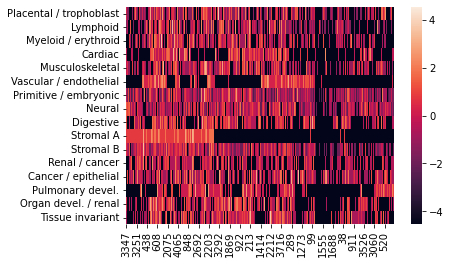

In [25]:
x = chr11_ce.iloc[:,3:]
Z = hierarchy.ward(x)
optimal_order = hierarchy.leaves_list(hierarchy.optimal_leaf_ordering(Z, x))
y = x.reindex(optimal_order)
y = np.transpose(y)
y=y.reindex(clr_scheme.keys())
ax = sns.heatmap(y)

### Take the max enrichment to score the component distribution for each region

In [13]:
chr11_ce.iloc[chr11_ce.iloc[:,3:].max(axis=1).sort_values(ascending=False).index,:].reset_index().head()

,index,seqname,start,end,Tissue invariant,Placental / trophoblast,Neural,Primitive / embryonic,Digestive,Lymphoid,Musculoskeletal,Stromal B,Myeloid / erythroid,Cancer / epithelial,Pulmonary devel.,Renal / cancer,Stromal A,Organ devel. / renal,Vascular / endothelial,Cardiac
0,1032,chr11,33859000,33884000,-4.539443,0.159163,0.358784,0.332675,-4.539443,-1.506332,-1.136906,-4.539443,4.539443,-0.934397,-4.539443,-0.546856,-4.539443,0.309815,0.217505,-4.539443
1,3355,chr11,109648800,109673800,-0.676824,-4.539443,0.581177,-0.082363,-4.539443,-4.539443,0.448056,-0.452459,-0.919989,4.491868,1.033443,-4.539443,-4.539443,-0.690185,0.217505,-0.269289
2,3189,chr11,104411000,104436000,-0.676824,0.574200,-0.641216,-0.345397,-0.552792,-1.506332,-0.136906,-2.037421,0.080011,0.650566,-4.539443,-4.539443,-4.539443,-0.690185,0.217505,4.254273
3,2939,chr11,96318800,96343800,1.323176,2.159163,0.095750,-0.082363,-0.552792,0.493668,-4.539443,1.769934,1.401939,-4.539443,1.033443,1.453144,0.811801,1.631743,-4.539443,4.123029
4,3662,chr11,119358800,119383800,0.323176,1.574200,-0.641216,1.332675,1.769136,1.953100,0.863094,-0.452459,1.401939,0.065603,-4.539443,0.453144,0.811801,1.631743,-4.539443,4.052639


### Evaluating quality of a region using unbiased coranking using SNR and Mean Cosine Simialrity(MCS)

#### Read in coranks3: DHSs ranked according to mean co-ranks of SNR and MCS

In [14]:
coranks3=pd.read_csv('../../ranking_metrics/results/coranked_metrics3',sep='\t')
coranks3

,means-cos_snr,max_metric
0,2403534.5,mean_cosine_similarity
1,1670757.0,snr
2,378904.5,snr
3,1386832.0,snr
4,1950693.5,snr
...,...,...
3591893,3122645.5,snr
3591894,1912274.0,snr
3591895,998487.0,snr
3591896,2735793.5,snr


#### Read in chr11 25KB regions summary statistics: it says coranks3 simply because it was the third combination of co-ranking AJ tried

In [16]:
chr11_info = pd.read_csv('../results/summary_stats_new_maxMean/chr11_stats_coranks3_new_maxMean',sep='\t')
chr11_info

,seqname,start,end,no_of_dhs,sum_coranked_metrics3,mean_coranked_metrics3,std_coranked_metrics3,no_of_unique_components,variance_comp
0,chr11,89800,114800,3,3793896.0,1.264632e+06,190649.059589,1,0.000000
1,chr11,135800,160800,1,1765417.5,1.765418e+06,0.000000,1,0.000000
2,chr11,167200,192200,14,27101454.0,1.935818e+06,779835.816609,6,2.494898
3,chr11,192200,217200,80,189985908.5,2.374824e+06,502801.707983,12,7.948594
4,chr11,230800,255800,47,101638756.0,2.162527e+06,629498.129610,13,9.521050
...,...,...,...,...,...,...,...,...,...
4146,chr11,134915200,134940200,27,49957547.5,1.850280e+06,639235.056535,11,7.015089
4147,chr11,134948600,134973600,46,92777818.5,2.016909e+06,570657.262959,9,4.009452
4148,chr11,134973600,134998600,54,93096300.5,1.724006e+06,718292.916191,9,3.830247
4149,chr11,135007600,135032600,38,72670975.5,1.912394e+06,634500.338308,12,7.880886


## Use CLT to estimate significance of 'k' DHSs in a window of 25 KB:

In [17]:
population_mean = np.mean(coranks3.iloc[:,0])
print(population_mean)
population_std_dev = np.std(coranks3.iloc[:,0])
print(population_std_dev)

1795949.5
751906.9786031414


#### For each window of $'n'$ DHSs, $\bar{x}$ is the its mean, $\mu=1795949.5$ is the population mean and $\sigma=751906.98$ is the population std. deviation
$ H_0 (Null Hypothesis): \mu=1795949.5\\$
z-score to conduct one tailed significance test for each window of $'n'$ DHSs:
$z = \frac{\bar{x}-\mu}{\sigma/\sqrt(n)}$

In [20]:
#pvals_chr11=pd.DataFrame(data=norm.sf(abs(chr11_info.mean_coranked_metrics3-population_mean)/(population_std_dev/np.sqrt(chr11_info.no_of_dhs)))*2,columns=['pvalue'])
#pvals_chr11=pvals_chr11.sort_values(by='pvalue')
#sorted_quality=pd.concat([chr11_info.iloc[pvals_chr11.index,:],pvals_chr11],axis=1)
#sorted_quality=sorted_quality.reset_index()
z = (chr11_info.mean_coranked_metrics3-population_mean)/(population_std_dev/np.sqrt(chr11_info.no_of_dhs))
pvals_chr=pd.DataFrame(columns=['pvalue'])
for j in range(len(z)):
    if z[j]>0:
        pvals_chr.loc[j,'pvalue'] = 1-norm.cdf(z[j])
    else:
        pvals_chr.loc[j,'pvalue'] = norm.cdf(z[j])
pvals_chr=pvals_chr.sort_values(by='pvalue')
sorted_quality=pd.concat([chr11_info.iloc[pvals_chr.index,:],pvals_chr],axis=1)
sorted_quality=sorted_quality.reset_index()

In [21]:
sorted_quality

,index,seqname,start,end,no_of_dhs,sum_coranked_metrics3,mean_coranked_metrics3,std_coranked_metrics3,no_of_unique_components,variance_comp,pvalue
0,969,chr11,31797600,31822600,93,230883797.5,2.482621e+06,362743.218988,12,4.884727,0.0
1,72,chr11,2509800,2534800,102,256931683.0,2.518938e+06,427505.743613,13,7.197712,0.0
2,2117,chr11,69626000,69651000,85,210999490.0,2.482347e+06,404394.953853,15,11.869343,0.0
3,1997,chr11,65851200,65876200,90,230635125.0,2.562612e+06,366546.728622,11,9.448889,0.0
4,3662,chr11,119358800,119383800,87,214408284.0,2.464463e+06,351291.149678,14,13.435857,0.0
...,...,...,...,...,...,...,...,...,...,...,...
4146,1058,chr11,34689200,34714200,19,34106882.0,1.795099e+06,497490.998408,6,3.191136,0.498033
4147,431,chr11,14152800,14177800,9,16174577.5,1.797175e+06,385207.351709,6,2.666667,0.498049
4148,3441,chr11,112279600,112304600,51,91619603.5,1.796463e+06,769668.088479,13,11.410227,0.498055
4149,780,chr11,25629800,25654800,20,35928460.0,1.796423e+06,659752.857032,7,1.827500,0.498876


## Co-ranking based on quality of DHSs in a region according unbiased co-ranking metric and component distribution as described above

In [22]:
sorted_ce=chr11_ce.iloc[chr11_ce.iloc[:,3:].max(axis=1).sort_values(ascending=False).index,:].reset_index()

In [23]:
chr11_corank_quality_density_component_distribution = chr11_info[['seqname','start','end','no_of_dhs']].copy()
for i in chr11_info.index:
    chr11_corank_quality_density_component_distribution.loc[i,'mean_corank']=(np.where(sorted_quality.iloc[:,0]==i)[0][0]+np.where(sorted_ce.iloc[:,0]==i)[0][0])/2

In [24]:
chr11_corank_quality_density_component_distribution.sort_values(by='mean_corank').reset_index()

,index,seqname,start,end,no_of_dhs,mean_corank
0,3662,chr11,119358800,119383800,87,4.0
1,160,chr11,5262600,5287600,43,20.0
2,3614,chr11,117861400,117886400,78,22.5
3,60,chr11,2127200,2152200,76,41.5
4,3880,chr11,126261800,126286800,61,55.0
...,...,...,...,...,...,...
4146,1635,chr11,54283400,54308400,4,4091.0
4147,1668,chr11,55368000,55393000,1,4103.0
4148,2675,chr11,87678200,87703200,3,4106.0
4149,431,chr11,14152800,14177800,9,4111.0


#### Third hit above is actually a part of the beta-globin region on chromosome 11

#### The results above indicate that coranking of component distribution and quality of DHSs in a given 25kb genomic region select regions that are relatively homogenous in terms of NMF components and its constituent DHSs have relatively stronger representation in biosamples of the same NMF components.